In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [6]:
dt = 0.1
length = 10000
T = dt*length
D = 1.0
density =2.0
sigma = 1.0
# from these parameters we need to calculate over how much space
# we need to place particles
max_sig = np.sqrt(2*D*T+sigma**2)
L = max_sig*6 # six sigma may be enough, it may not - lets see
N = int(density*2*L)
print(N,' particles needed for T=',T)
print('Length of the box:',2*L)
print('Density:',N/2/L)
act_density = N/2/L

1073  particles needed for T= 1000.0
Length of the box: 536.790461912
Density: 1.99891778289


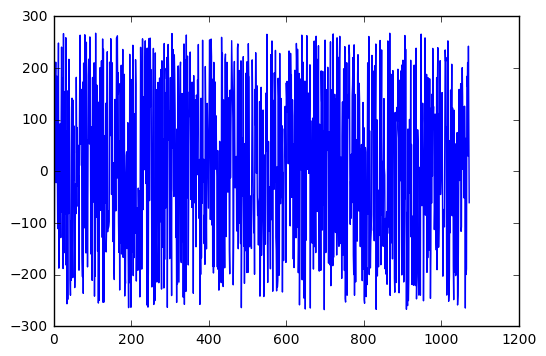

In [3]:
# generate positions for all particles
positions=2*L*np.random.random(size=(N,))-L
plt.plot(positions)

0.0 0.0817149761024 0.18407244264
0.0 0.0971581200704 0.234456162202
0.0 0.108638284622 0.281170298459
0.0 0.117076523964 0.325000928478
0.0 0.123229187985 0.366547501859
0.0 0.127670589623 0.406199740801
0.0 0.13082625323 0.444199619518
0.0 0.133009994363 0.480700065398
0.0 0.134454085829 0.515804682875
0.0 0.135331680867 0.549591250962
0.0 0.135772965105 0.58212448726
0.0 0.135876687013 0.613462481336
0.0 0.135718397375 0.643659669906
0.0 0.135356371017 0.672768050706
0.0 0.134835896991 0.700837571572
0.0 0.134192414829 0.727916180645
0.0 0.133453828669 0.754049772319
0.0 0.13264223062 0.779282130863
0.0 0.13177519575 0.803654907609
0.0 0.130866763585 0.827207637491
0.0 0.129928188104 0.849977788731
0.0 0.128968515294 0.872000836307
0.0 0.127995031153 0.89331035027
0.0 0.127013611588 0.913938091829
0.0 0.126028997448 0.933914112015
0.0 0.125045012029 0.953266849458
0.0 0.124064734032 0.972023225099
0.0 0.123090635845 0.990208732587
0.0 0.122124694637 1.00784752376
0.0 0.121168482019 

(0, 10)

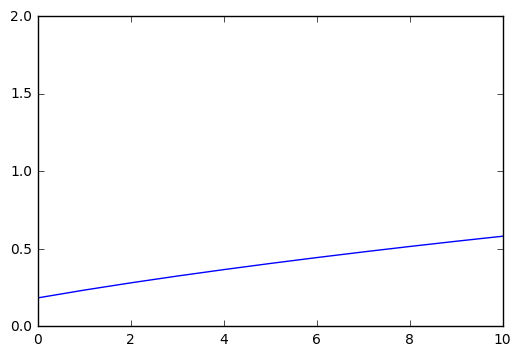

In [22]:
I = []
for i in range(length):
    intensities = sigma/np.sqrt(2*np.pi)/np.sqrt(2*D*i*dt+sigma**2)*np.exp(-positions**2/(2*(2*D*i*dt+sigma**2)))
    print(intensities.min(),intensities.max(),intensities.sum())
    I.append(intensities.sum())
I=np.array(I)
plt.plot(I)
plt.xlim((0,10))

In [15]:
I

array([-1.81484534, -1.76446162, -1.71774748, ..., -0.04237002,
       -0.0423656 , -0.04236117])

In [7]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),2*L)-L

NameError: name 'x' is not defined

In [ ]:
for path in paths:
    plt.plot(path,".")

In [ ]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=0)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

In [ ]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/2/L)

In [ ]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:1000]-1.0
t = np.arange(0,autocorr.size)*dt
plt.semilogx(t,autocorr,"o")

In [ ]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

In [ ]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(t,N,D,gamma,w0):
    return 1/N/(1+(D*t/w0**2))**gamma

In [ ]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 20
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [ ]:
corrfitPB_model=lm.Model(corrfitPB)
paramsPB = corrfitPB_model.make_params()
paramsPB['w0'].set(value=1,vary=False)
paramsPB['N'].set(value=20,vary=True)
paramsPB['D'].set(value=D,vary=True)
paramsPB['L'].set(value=L,vary=False)

resultPB = corrfitPB_model.fit(t=t,data=autocorr,params=paramsPB)

In [ ]:
print(resultPB.fit_report())

In [ ]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(t=t,data=autocorr,params=params)

In [ ]:
print(result.fit_report())

In [ ]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')

In [ ]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, resultPB.init_fit, 'k--')
plt.semilogx(t, resultPB.best_fit, 'r-')